In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf 6864-hw2
git clone https://github.com/lingo-mit/6864-hw2.git

Cloning into '6864-hw2'...


In [0]:
import sys
sys.path.append("/content/6864-hw2")

import numpy as np
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# **Introduction**

In this lab, you will explore two types of recurrent architectures to perform sequential classification. Specifically, you are asked to implement and train a vanilla RNN (no gate mechanism) and an LSTM for the task of Name Entity Recognition (NER). For details about NER, you can read [this](https://en.wikipedia.org/wiki/Named-entity_recognition) wikipage.

To complete this lab, you need to first understand the recurrent update equations introduced in lecture, and transform them into PyTorch code.

In NER, your task is to predict the correct name entity of each word in a sentence.
We are going to work with a dataset called MIT-Restaurants. We've helped you preprocessed the data. They now look like this:

In [3]:
def read_file(f_name):
    data = []
    with open(f_name, 'r') as f:
        for line in f:
            data.append(line.strip().split())
    return data

train_data = read_file('/content/6864-hw2/train.dat')
train_tags = read_file('/content/6864-hw2/train.tag')

test_data = read_file('/content/6864-hw2/test.dat')
test_tags = read_file('/content/6864-hw2/test.tag')

print('Total amount of training samples: %d' % len(train_data))
print('Total amount of testing samples: %d' % len(test_data))
print('Average sentence length in training data: %f' % (
    np.mean([len(sent) for sent in train_data])))

print('\nExample:')
print('The first sentence is: ' + str(train_data[0]))
print('Its corresponding name entity sequence is: ' + str(train_tags[0]))

Total amount of training samples: 7660
Total amount of testing samples: 1521
Average sentence length in training data: 9.206919

Example:
The first sentence is: ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
Its corresponding name entity sequence is: ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']


Here are some helper functions and more data preprocessing before we move on to implementing our models. No code to write in this section but please do understand it as some variables defined here will be used later for training and evaluation. 

In [4]:
# From train data, collect all unique word types as a set and add 'UNK' to it.
# Unseen words in test data will be turned into 'UNK'.
vocab_set = list(set([word for sent in train_data for word in sent])) + ['UNK']
num_vocabs = len(vocab_set)
print("Number of word types, including 'UNK': %d" % num_vocabs)

# Assign each word type an unique id.
vocab2id = {v : i for i, v in enumerate(vocab_set)}


# We also collect all tag (class) types and assign an unique id to each of them.
# There won't be unseen tag type in test data.
tag_set = list(set([tag for tag_seq in train_tags for tag in tag_seq]))
num_tags = len(tag_set)
print("Number of tag types: %d" % num_tags)
print('These are the tag types: ' + str(tag_set))

tag2id = {t : i for i, t in enumerate(tag_set)}
# Inverse dictionary of tag2id, you will need this during evaluation!
id2tag = {i : t for t, i in tag2id.items()}

Number of word types, including 'UNK': 3805
Number of tag types: 17
These are the tag types: ['B-Restaurant_Name', 'I-Amenity', 'I-Price', 'I-Rating', 'B-Hours', 'B-Rating', 'B-Dish', 'B-Price', 'B-Location', 'B-Amenity', 'I-Restaurant_Name', 'O', 'I-Location', 'I-Dish', 'B-Cuisine', 'I-Cuisine', 'I-Hours']


Now that you have understood what raw data look like, it's your turn to transform them into the format that our model actually takes as input: one-hot encoding. Hint: in tag_to_id function, the B-I-O refers to beginning, inside and outside. Each of them means the beginning of the tagging chunk, inside the tagging chunk and outside the tagging chunk. For more detailed explanation, please refer to the IOB2 format in [this](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) wikipage.

In [5]:
def one_hot_encoding(sent, vocab2id):
    # Example input `sent` (a list of words):
    # ['2', 'start', 'restaurants', 'with', 'inside', 'dining']

    one_hot = torch.zeros(len(sent), len(vocab2id))

    # Your code here!
    for i, word in enumerate(sent):
        if word not in vocab2id:
            word='UNK'
        index = vocab2id[word]
        one_hot[i,index] = 1
    return one_hot

def tag_to_id(tag_seq, tag2id):
    # Example input `tag_seq` (a list of tags):
    # ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']

    id_seq = torch.zeros(len(tag_seq), dtype=torch.long)
    # Your code here!
    for i, tag in enumerate(tag_seq):
        id_seq[i] = tag2id[tag]
    return id_seq


# Apply one-hot encoding to data.
train_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in train_data]
# Transform tag names into ids.
train_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in train_tags]

# train_data_oh_list should now be a list of 2d-tensors, each has shape (sent_len, num_vocabs)
# Note that to utilize the `shape` attribute, each element in the list should
# already be a torch tensor.
print("First sentence has shape: %s" % str(train_data_oh_list[0].shape))
print("Fifth sentence has shape: %s" % str(train_data_oh_list[4].shape))
# train_tags_id_list is a list of 1d-tensors, each that has shape (sent_len,)
print("first tag sequence has shape: %s" % train_tags_id_list[0].shape)
print("Fifth tag sequence has shape: %s" % train_tags_id_list[4].shape)


# Apply same conversion to test dataset.
test_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in test_data]
test_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in test_tags]

First sentence has shape: torch.Size([6, 3805])
Fifth sentence has shape: torch.Size([12, 3805])
first tag sequence has shape: 6
Fifth tag sequence has shape: 12


# **Part 1: Recurrent Neural Network (RNN)**

In this part, you will implement a vanilla RNN. You are not allowed to use the PyTorch built-in RNN/RNNCell modules--you will have to implement the update rules yourself. Please follow the formulation introduced in lecture.

In [0]:
class RNN(nn.Module):
    # A torch module implementing an RNN. The `forward` function should just
    # perform one step of update and output logits before softmax.

    #rnn_model = RNN(input_size=num_vocabs, hidden_size=128,output_size=num_tags)
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # `input_size`, `hidden_size`, and `output_size` are all int.
        print("RNN initializing - input size:",input_size,"hidden_size:", hidden_size,"output size:", output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Your code here!
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # `input` is a 2d-tensor of shape (1, input_size); `hidden` is another
        # 2d-tensor of shape (1, hidden_size), representing the hidden state of
        # the previous time step.

        # Your code here!
        outputs=torch.zeros(input.size()[0],num_tags)
        for word in input:
            word = word.view(1,-1)
            combined = torch.cat((word, hidden), 1)
            hidden = self.i2h(combined)
            output = self.i2o(combined)
            outputs=output if word==0 outputs.append(output)
        outputs = torch.cat(outputs)

        return outputs, hidden

    def initHidden(self):
        # Use to initialize hidden state everytime before running a sentence.
        return torch.zeros(1, self.hidden_size)
    

Now that you have defined your RNN model, we can start training it. We've provided the main training loop, but you will have to implement the fucntion `rnn_train_one_sample`, which takes a (sentence-tensor, tag-tensor)-pair as input and does one step of gradient update. To understand better what this function is supposed to do, you can go over the main training loop in the next section first.

In [7]:
learning_rate = 1e-3
rnn_hidden_size = 128

rnn_model = RNN(input_size=num_vocabs, hidden_size=rnn_hidden_size,
                output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)


def rnn_train_one_sample(model, sent_tensor, tag_tensor):
    # Run through a sentence, generate output, compute loss, and perform one
    # gradient update. Sentence and tag are represented as a 2d-tensor
    # `sent_tensor` and a 1d-tensor `tag_tensor`, respectively.

    # Initialize hidden state.
    hidden = model.initHidden().to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    # Your code here!
    rnn_optimizer.zero_grad()
    outputs, hidden = model(sent_tensor,hidden)
    loss = loss_fn(outputs, tag_tensor)
    loss.backward()

    total_norm=0
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    for p in list(filter(lambda p: p.grad is not None, model.parameters())):
      p.data.add_(-learning_rate, p.grad.data)
      param_norm = p.grad.data.norm(2)
      total_norm += param_norm.item()

    rnn_optimizer.step()

    return outputs, loss.item(), total_norm

RNN initializing - input size: 3805 hidden_size: 128 output size: 17


Here's the main training loop for training RNN:

In [8]:
import time
import math
from matplotlib import pyplot as plt


n_epochs = 5
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
current_norm = 0
all_losses = []
all_norms = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

rnn_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss, norm = rnn_train_one_sample(rnn_model, sent_tensor, tag_tensor)
        current_loss += loss
        current_norm += norm

        if iter_count % print_every == 0:
            print('%d %s %.4f %.4f' % (iter_count, timeSince(start), loss, norm))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            all_norms.append(current_norm / plot_every)
            current_loss = 0
            current_norm = 0

        iter_count += 1

0 0m 0s 2.8362 0.8811
1000 0m 4s 2.6755 1.9310
2000 0m 8s 0.9903 1.7627
3000 0m 13s 1.8646 1.7172
4000 0m 18s 1.4746 1.6186
5000 0m 22s 0.4417 1.3255
6000 0m 26s 0.6302 1.6753
7000 0m 30s 1.1058 1.6504
8000 0m 34s 0.3656 1.6710
9000 0m 39s 1.4546 1.7557
10000 0m 43s 0.3607 1.5480
11000 0m 48s 0.4123 1.3928
12000 0m 52s 0.1702 0.8370
13000 0m 57s 0.7793 1.7787
14000 1m 1s 0.0626 0.4487
15000 1m 5s 1.0701 1.7280
16000 1m 9s 0.7219 1.5200
17000 1m 13s 0.1115 0.8644
18000 1m 17s 0.2599 1.6462
19000 1m 22s 0.1179 1.0890
20000 1m 26s 1.3990 1.6425
21000 1m 30s 0.1252 0.6994
22000 1m 34s 0.5773 1.6752
23000 1m 38s 0.5614 1.8395
24000 1m 43s 0.0567 0.4148
25000 1m 47s 0.0743 0.6869
26000 1m 51s 0.2967 1.6527
27000 1m 56s 0.1212 1.3133
28000 2m 0s 0.0697 0.4496
29000 2m 4s 1.7376 1.8191
30000 2m 9s 0.0631 0.4371
31000 2m 13s 0.0110 0.0925
32000 2m 17s 0.0300 0.2091
33000 2m 22s 0.2194 1.6144
34000 2m 26s 0.1313 1.4936
35000 2m 31s 0.5374 1.5646
36000 2m 35s 0.0446 0.4101
37000 2m 39s 0.1758 1.5

Now let's plot the learning curve. The x-axis is the training iterations and the y-axis is the training loss. The loss should be going down.

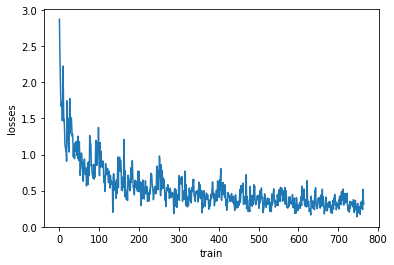

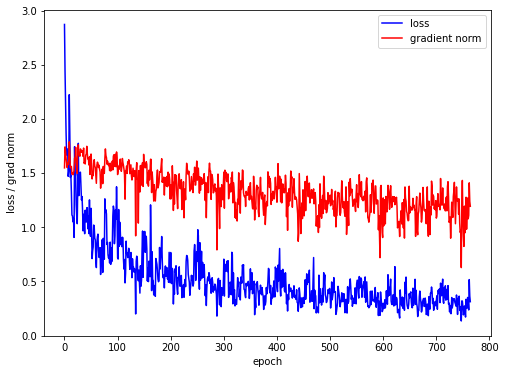

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.xlabel('train')
plt.ylabel('losses')
plt.plot(all_losses)

#plt.figure()
#plt.xlabel('train')
#plt.ylabel('gradients')
#plt.plot(all_norms)

plt.figure(figsize=(8, 6))
plt.xlabel('epoch')
plt.ylabel('loss / grad norm')
plt.plot(all_losses, 'b', label="loss")
plt.plot(all_norms, 'r', label="gradient norm")
plt.legend()

Now that we have trained our RNN, it's time to evaluate it on the test set.

In [0]:
# Evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support


def evaluate_result(true_tag_list, predicted_tag_list):
    # Example: true_tag_list/predicted_tag_list:
    #   [[‘O’, ‘O’, ‘I’, ‘N’, ...]
    #    [‘I’, ‘I’, ‘O’, ‘N’, ...]],
    # each sublist corresponds to an input sentence.
    p_list = []
    r_list = []
    f1_list = []
    for true_tag, predicted_tag in zip(true_tag_list, predicted_tag_list):
        p, r, f1, _ = precision_recall_fscore_support(true_tag, predicted_tag,
                                                      average='macro',
                                                      zero_division=0)
        p_list.append(p)
        r_list.append(r)
        f1_list.append(f1)
    
    return np.mean(p_list), np.mean(r_list), np.mean(f1_list)

# Make prediction for one sentence.
def rnn_predict_one_sent(model, sent_tensor):
    hidden = model.initHidden().to(device)

    predicted_tag_id = None
    # Your code here!
    outputs, hidden = model(sent_tensor,hidden)
    predicted_tag_id = outputs.topk(1)[1]
                               
    return predicted_tag_id

rnn_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = rnn_predict_one_sent(rnn_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach()[:,0].cpu().numpy()])

# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

(0.7244514530443986, 0.7304252185612555, 0.7203154864070566)

## **Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Compute the gradient norm of all trainable parameters along the training. Plot a figure similar to what we did for training loss (x-axis is training iterations and y-axis is avg. gradient norm value). Describe what you find. Hint: gradient norm is the L2 norm of of the gradient vector.

2. Try to do learning with gradient clipping. Why should we use gradient clipping? What is the effect of gradient clipping? Could we use larger learning rate after gradient clipping? Why? Hint: use torch.nn.utils.clip_grad_norm(model.parameters(), clip) after loss.backward(). You can try various clipping range. A good starting point is clip = 5.

# **Part 2: Long Short-Term Memory (LSTM)**

In part 2, you will implement your own LSTM. Same in part 1, you are not allowed to use PyTorch built-in LSTM/LSTMCell modules. For reference, you can look up the wikipage for the [LSTM architecture](https://en.wikipedia.org/wiki/Long_short-term_memory).

In [0]:
class LSTM(nn.Module):
    # A torch module implementing an LSTM. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        # Your code here!
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
        self.ih2g = nn.Linear(input_size + hidden_size, hidden_size)
        #self.h2h = nn.Linear(input_size + hidden_size, output_size)
        self.output = nn.Linear(hidden_size, output_size)


    def forward(self, input, hidden, memory):
        # `input` is a 2d-tensor of shape (1, input_size);
        # `hidden` and `memory` are both 2d-tensors of shape (1, hidden_size),
        # representing the hidden and memory states of the previous time step.

        output = None
        memory = None
        # Your code here!
        combined = torch.cat((input, hidden), 1) #v=[v1;v2;..;vn]truncated vector
        gates = self.ih2g(combined) #h=f(v) hidden layer
        
        f_gate = self.sigmoid(gates)
        i_gate = self.sigmoid(gates)
        c_gate = self.tanh(gates)
        o_gate = self.sigmoid(gates)
        
        memory = (f_gate * hidden) + (i_gate * c_gate)
        hidden = o_gate * self.tanh(memory)
        output = self.output(hidden)

        return output, hidden, memory

    def initHidden(self):
        # Initialize hidden and memory states.
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))

Same with part 1, we provide the main training loop for training LSTM, but you will need to implement the `lstm_train_one_sample` function, and also apply gradient clipping.

In [0]:
learning_rate = 1e-3
lstm_hidden_size = 128

lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                  output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),  lr=learning_rate)

def lstm_train_one_sample(model, sent_tensor, tag_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    # Your code here!
    outputs=[]
    for word in sent_tensor:
      word = word.view(1,3805)
      #tag = tag.view(1)
      output, hidden, memory = model(word, hidden, memory) #v=[v1;v2;..;vn]truncated vector
      outputs.append(output)
    outputs=torch.cat(outputs)
    loss = criterion(outputs, tag_tensor)

    lstm_optimizer.zero_grad()
    loss.backward()

    # Your Code here!
      
    lstm_optimizer.step()

    return outputs, loss.item()

LSTM main training loop:

In [0]:
n_epochs = 5
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

lstm_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = lstm_train_one_sample(lstm_model, sent_tensor, tag_tensor)
        current_loss += loss

        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

        iter_count += 1

0 0m 0s 2.8119
1000 0m 7s 2.9156
2000 0m 14s 0.9511
3000 0m 21s 2.0631
4000 0m 29s 1.4771
5000 0m 37s 0.2890
6000 0m 44s 0.4456
7000 0m 50s 0.9252
8000 0m 57s 0.3749
9000 1m 5s 1.0803
10000 1m 12s 0.2917
11000 1m 19s 0.4706
12000 1m 27s 0.0587
13000 1m 34s 0.0977
14000 1m 41s 0.0332
15000 1m 48s 0.9216
16000 1m 55s 0.2572
17000 2m 2s 0.0162
18000 2m 9s 0.1051
19000 2m 18s 0.0134
20000 2m 25s 1.3743
21000 2m 32s 0.1222
22000 2m 39s 0.5149
23000 2m 46s 0.1571
24000 2m 54s 0.0124
25000 3m 1s 0.0475
26000 3m 8s 0.4094
27000 3m 16s 0.0167
28000 3m 24s 0.0159
29000 3m 31s 1.7553
30000 3m 38s 0.0361
31000 3m 45s 0.0137
32000 3m 52s 0.0115
33000 3m 59s 0.1000
34000 4m 7s 0.0682
35000 4m 15s 0.4000
36000 4m 22s 0.0549
37000 4m 29s 0.1569
38000 4m 36s 0.3617


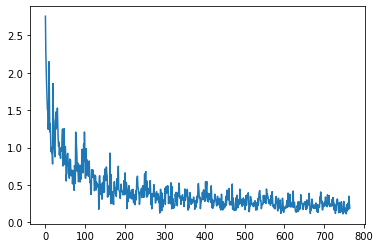

In [0]:
plt.figure()
plt.plot(all_losses)

Now let's evaluate our LSTM model.

In [0]:
def lstm_predict_one_sent(model, sent_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    # Your code here!
    predicted_tag_id=[]
    for word in sent_tensor:
      word = word.view(1,3805)
      outputs, hidden, memory = model(word,hidden, memory)
      index=torch.max(outputs,1)[1]
      predicted_tag_id.append(index)
      
    predicted_tag_id = torch.cat(predicted_tag_id)
    
    return predicted_tag_id


lstm_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = lstm_predict_one_sent(lstm_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])


# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

(0.7822559511642116, 0.7854810761178328, 0.7776267503641529)

## **Part 2: Lab writeup**

Your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Change lstm_hidden_size so that LSTM has approximately the same amount of parameters as RNN. Hint: use sum(p.numel() for p in model.parameters() if p.requires_grad) to find the number of trainable parameters. Re-train the LSTM model and discuss your findings.

2. Same in part 1 writeup, plot the gradient norm figure for LSTM. Discuss your findings.

3. Currently we update model parameters for each sample (1 sample = 1 iteration). In practice, we usually train with a mini-batch (mB): the entire dataset of N samples is split into N/mB batches, and use one mini-batch for each update. Briefly describe how to do batching in our dataset. Hint: each sentence can have variable length.